In [12]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

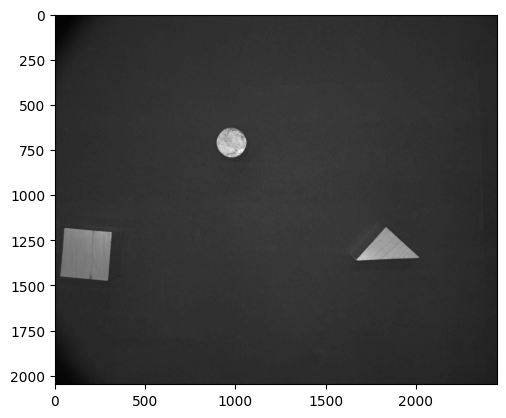

In [13]:
img_path = "/mnt/c/Users/zmrzl/OneDrive/Documents/PROJEKTY/005_DIPLOMOVA_PRACE/003_DATASET/DS/DS8/2.png"

img = cv.imread(img_path, 0)
# img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img, cmap="gray")

In [14]:
ret, thresh = cv.threshold(img, 80, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

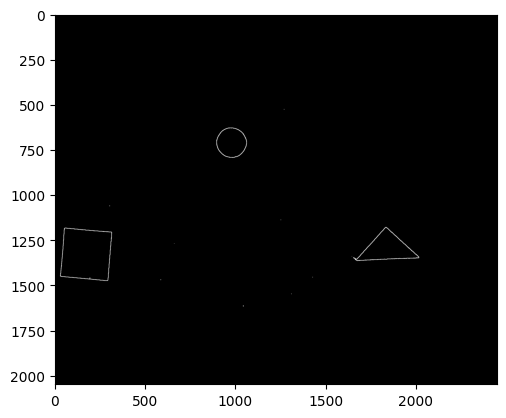

In [15]:
img_contours = np.zeros_like(img)
cv.drawContours(img_contours, contours, -1, (255, 255, 255), 2)
plt.imshow(img_contours, cmap="gray")

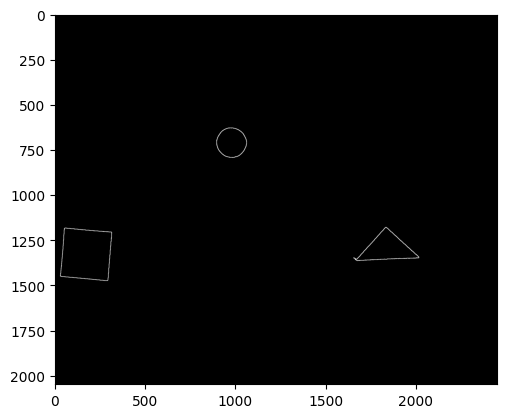

In [16]:
min_area = 2000
filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_area]

img_contours = np.zeros_like(img)
cv.drawContours(img_contours, filtered_contours, -1, (255, 255, 255), 2)
plt.imshow(img_contours, cmap="gray")

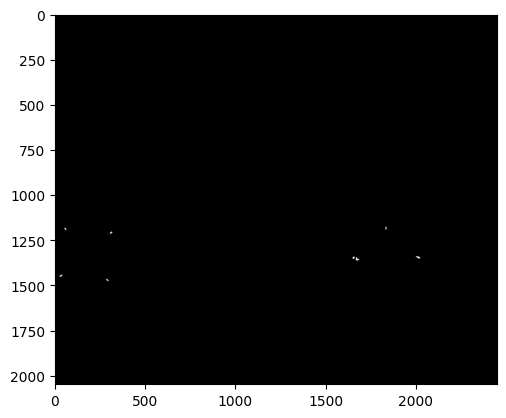

In [17]:
corners = cv.cornerHarris(img_contours, 10, 31, 0.1)
_, corners = cv.threshold(corners ,0.01*corners.max(),255,0)
corners = np.uint8(corners)
plt.imshow(corners, cmap="gray")

In [18]:
from math import atan2, cos, sin, sqrt, pi
# https://automaticaddison.com/how-to-determine-the-orientation-of-an-object-using-opencv/
def drawAxis(img, p_, q_, color, scale):
    p = list(p_)
    q = list(q_)
    
    ## [visualization1]
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
    
    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
    
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv.LINE_AA)
    ## [visualization1]
 
 
def getOrientation(pts, img):
    ## [pca]
    # Construct a buffer used by the pca analysis
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
    
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    ## [pca]
    
    ## [visualization]
    # Draw the principal components
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    drawAxis(img, cntr, p1, (255, 255, 0), 1)
    drawAxis(img, cntr, p2, (0, 0, 255), 5)
    
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    ## [visualization]
    
    # Label with the rotation angle
    label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees"
    textbox = cv.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 250, cntr[1] + 10), (255,255,255), -1)
    cv.putText(img, label, (cntr[0], cntr[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv.LINE_AA)
    
    return angle

114.96653468665531
-2.6428243170642025
34.66031922856785


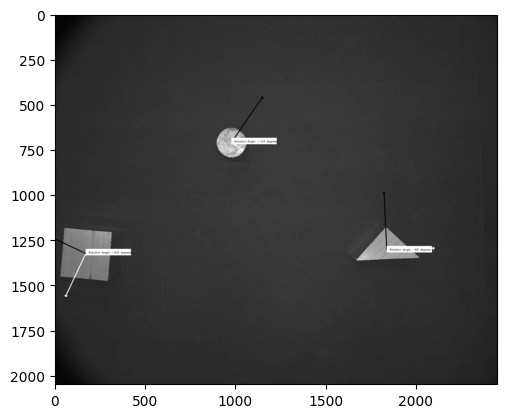

In [19]:
for i, c in enumerate(filtered_contours):
    
    # Calculate the area of each contour
    area = cv.contourArea(c)
    
    # Ignore contours that are too small or too large
    if area < 1500 or 100000 < area:
     continue
    
    # Draw each contour only for visualisation purposes
    cv.drawContours(img, contours, i, (0, 0, 255), 2)
    
    # Find the orientation of each shape
    angle = getOrientation(c, img)
    print(angle * 180 / np.pi)
plt.imshow(img, cmap="gray")

86.1595488460623


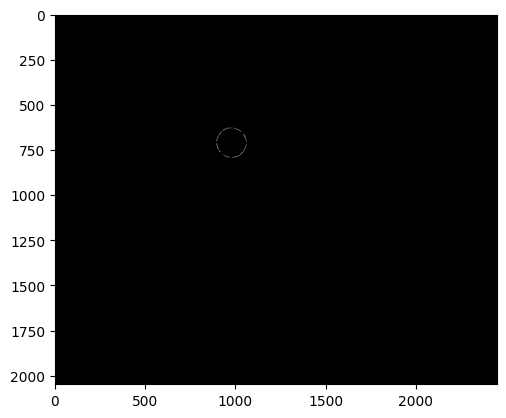

In [20]:
hu_moments = cv.HuMoments(cv.moments(filtered_contours[2])).flatten()
rotation_angle = np.arctan2(hu_moments[1], hu_moments[2]) * 180 / np.pi
print(rotation_angle)

img_hu = np.zeros_like(img)
cv.drawContours(img_hu, filtered_contours[2], -1, (255, 255, 255), 2)
plt.imshow(img_hu, cmap="gray")


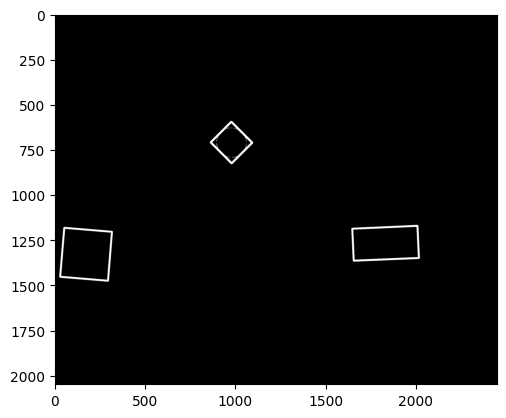

In [23]:
rect = cv.minAreaRect(filtered_contours[1])
box = cv.boxPoints(rect)
box = np.intp(box)
cv.drawContours(img_hu, [box], 0, (255, 255, 0), thickness=10)
plt.imshow(img_hu, cmap="gray")